In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met, u_darrays as uda
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import matplotlib.patches as patches
import pickle
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [9]:
cd ..

/home/ck/pythonWorkspace


In [11]:
region = 'timbuktu'
sahel = [-12,12,9,19]
x=2
ouaga=[-1.52-x,-1.52+x,11.38,13.38]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 12.51,14.51] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 15.77,17.77] #16.7666° N, 3.0026° W

regions = {'sahel':sahel, 'ouaga':ouaga, 'niamey':niamey, 'timbuktu':timbuktu}
domain = regions[region]


fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors_'+region+'.p', "rb")) #'+region+'
#ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors_sahel.p', "rb")) #'+region+'

shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
tcwvfac_all =  np.array(ftcw['rel']) 

precip_all = ftcw['prcp_hist']

tcabsfac = np.mean(ftcw['abs']) #1.21 # absolute change

tcabserr = np.std(ftcw['abs']) #0.06 #mm h
tcrelerr = np.std(ftcw['rel']) #0.18 #%

In [12]:
print('Shear scaling', shearfac)
print('TCW scaling', tcwvfac_all)

Shear scaling 0.795388088560751
TCW scaling [1.63028385 1.44089633 1.63028385 1.43273678 1.20676634]


In [13]:
ftcw

{'rel': array([1.63028385, 1.44089633, 1.63028385, 1.43273678, 1.20676634]),
 'abs': [1.5427981817116558,
  1.220563132674635,
  1.2164046264962813,
  1.0460477938911603,
  0.8726393532823121],
 'tcw_hist': array([28.06, 38.43, 41.78, 44.74, 51.23]),
 'prcp_hist': [29.491479607434115,
  32.55351567668454,
  31.173335400372356,
  32.66488233871698,
  37.04554267681757],
 'tcw_fut': array([41.18, 56.  , 60.88, 64.77, 74.41]),
 'prcp_fut': [49.73299175149104,
  53.998809917777876,
  54.40666376645133,
  53.617219650356915,
  57.273322885901564]}

In [14]:
def calc_mcs_stuff(dic, domain):
    m1=7
    m2=9

    dicout = dic[(dic.lon>=domain[0])&(dic.lon<=domain[1])&(dic.lat>=domain[2])&(dic.lat<=domain[3])& (dic.month>=m1) & (dic.month<=m2) & (dic.q925>=8.) & (dic.shear>0) &  (dic.prcp>=0.1) & (dic.theta_e>=-40) & (dic.area>=5000) & (dic.tmin<=-55)]
    
    return dicout

In [15]:
#print(' Ouaga fraction MCS with TCW < maxPrecip Hist / Fut', np.sum(cp4hist_mcs95['tcwv']<cp4hist_mcs95['prcp'])/np.sum(np.isfinite(cp4hist_mcs95['prcp']))*100, np.sum(cp4fut_mcs95['tcwv']<cp4fut_mcs95['prcp'])/np.sum(np.isfinite(cp4fut_mcs95['prcp']))*100 )

In [16]:
dd = [-12,12,9,19]
obs_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "rb"))
cp4hist_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "rb"))
cp4fut_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "rb"))

obs_mcs95_prange = calc_mcs_stuff(obs_mcs_d, dd).quantile([0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99])
cp4hist_mcs95_prange = calc_mcs_stuff(cp4hist_mcs_d, dd).quantile([0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99])
cp4fut_mcs95_prange = calc_mcs_stuff(cp4fut_mcs_d, dd).quantile([0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99])

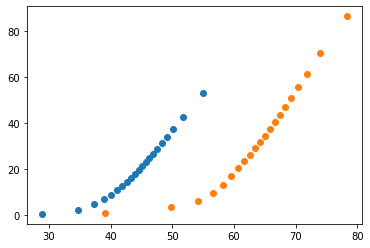

In [17]:
plt.scatter(cp4hist_mcs95_prange.tcwv, cp4hist_mcs95_prange.prcp)
plt.scatter(cp4fut_mcs95_prange.tcwv, cp4fut_mcs95_prange.prcp)

In [18]:
def calc_regional(dd):

    cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc').sel(longitude=slice(dd[0],dd[1]), latitude=slice(dd[2],dd[3])).mean()
    cp4_tcw_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_tcwv_daily.nc').sel(longitude=slice(dd[0],dd[1]), latitude=slice(dd[2],dd[3])).mean()
    
    cp4_u925_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u925_daily.nc').sel(longitude=slice(dd[0],dd[1]), latitude=slice(dd[2],dd[3])).mean()
    cp4_u925_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u925_daily.nc').sel(longitude=slice(dd[0],dd[1]), latitude=slice(dd[2],dd[3])).mean()
    cp4_u600_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u600_daily.nc').sel(longitude=slice(dd[0],dd[1]), latitude=slice(dd[2],dd[3])).mean()
    cp4_u600_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u600_daily.nc').sel(longitude=slice(dd[0],dd[1]), latitude=slice(dd[2],dd[3])).mean()
    
    cp4_shear_hist = cp4_u925_hist-cp4_u600_hist
    cp4_shear_fut = cp4_u925_fut-cp4_u600_fut
    
    cp4_tcw_rel = (cp4_tcw_fut-cp4_tcw_hist)/cp4_tcw_hist
    cp4_tcw = (cp4_tcw_fut-cp4_tcw_hist)
    
    cp4_shear_abs = cp4_shear_fut-cp4_shear_hist
    
    return cp4_tcw_hist, cp4_tcw_fut, cp4_tcw_rel, cp4_shear_abs

In [24]:
cmip_tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc', concat_dim='model_name', combine='by_coords').load()

In [25]:
model_names = cmip_tcw_map.model_name

In [26]:
def calc_mcs(dd):

    obs_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "rb"))
    cp4hist_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "rb"))
    cp4fut_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "rb"))

    obs_mcs95 = calc_mcs_stuff(obs_mcs_d, dd).quantile(0.95)
    cp4hist_mcs95 = calc_mcs_stuff(cp4hist_mcs_d, dd).quantile(0.95)
    cp4fut_mcs95 = calc_mcs_stuff(cp4fut_mcs_d, dd).quantile(0.95)
    
    obs_mcs95_max = calc_mcs_stuff(obs_mcs_d, dd).quantile(0.9999)
    cp4hist_mcs95_max = calc_mcs_stuff(cp4hist_mcs_d, dd).quantile(0.9999)
    cp4fut_mcs95_max = calc_mcs_stuff(cp4fut_mcs_d, dd).quantile(0.9999)
    
    return cp4hist_mcs95, cp4fut_mcs95, obs_mcs95, cp4hist_mcs95_max, cp4fut_mcs95_max, obs_mcs95_max

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

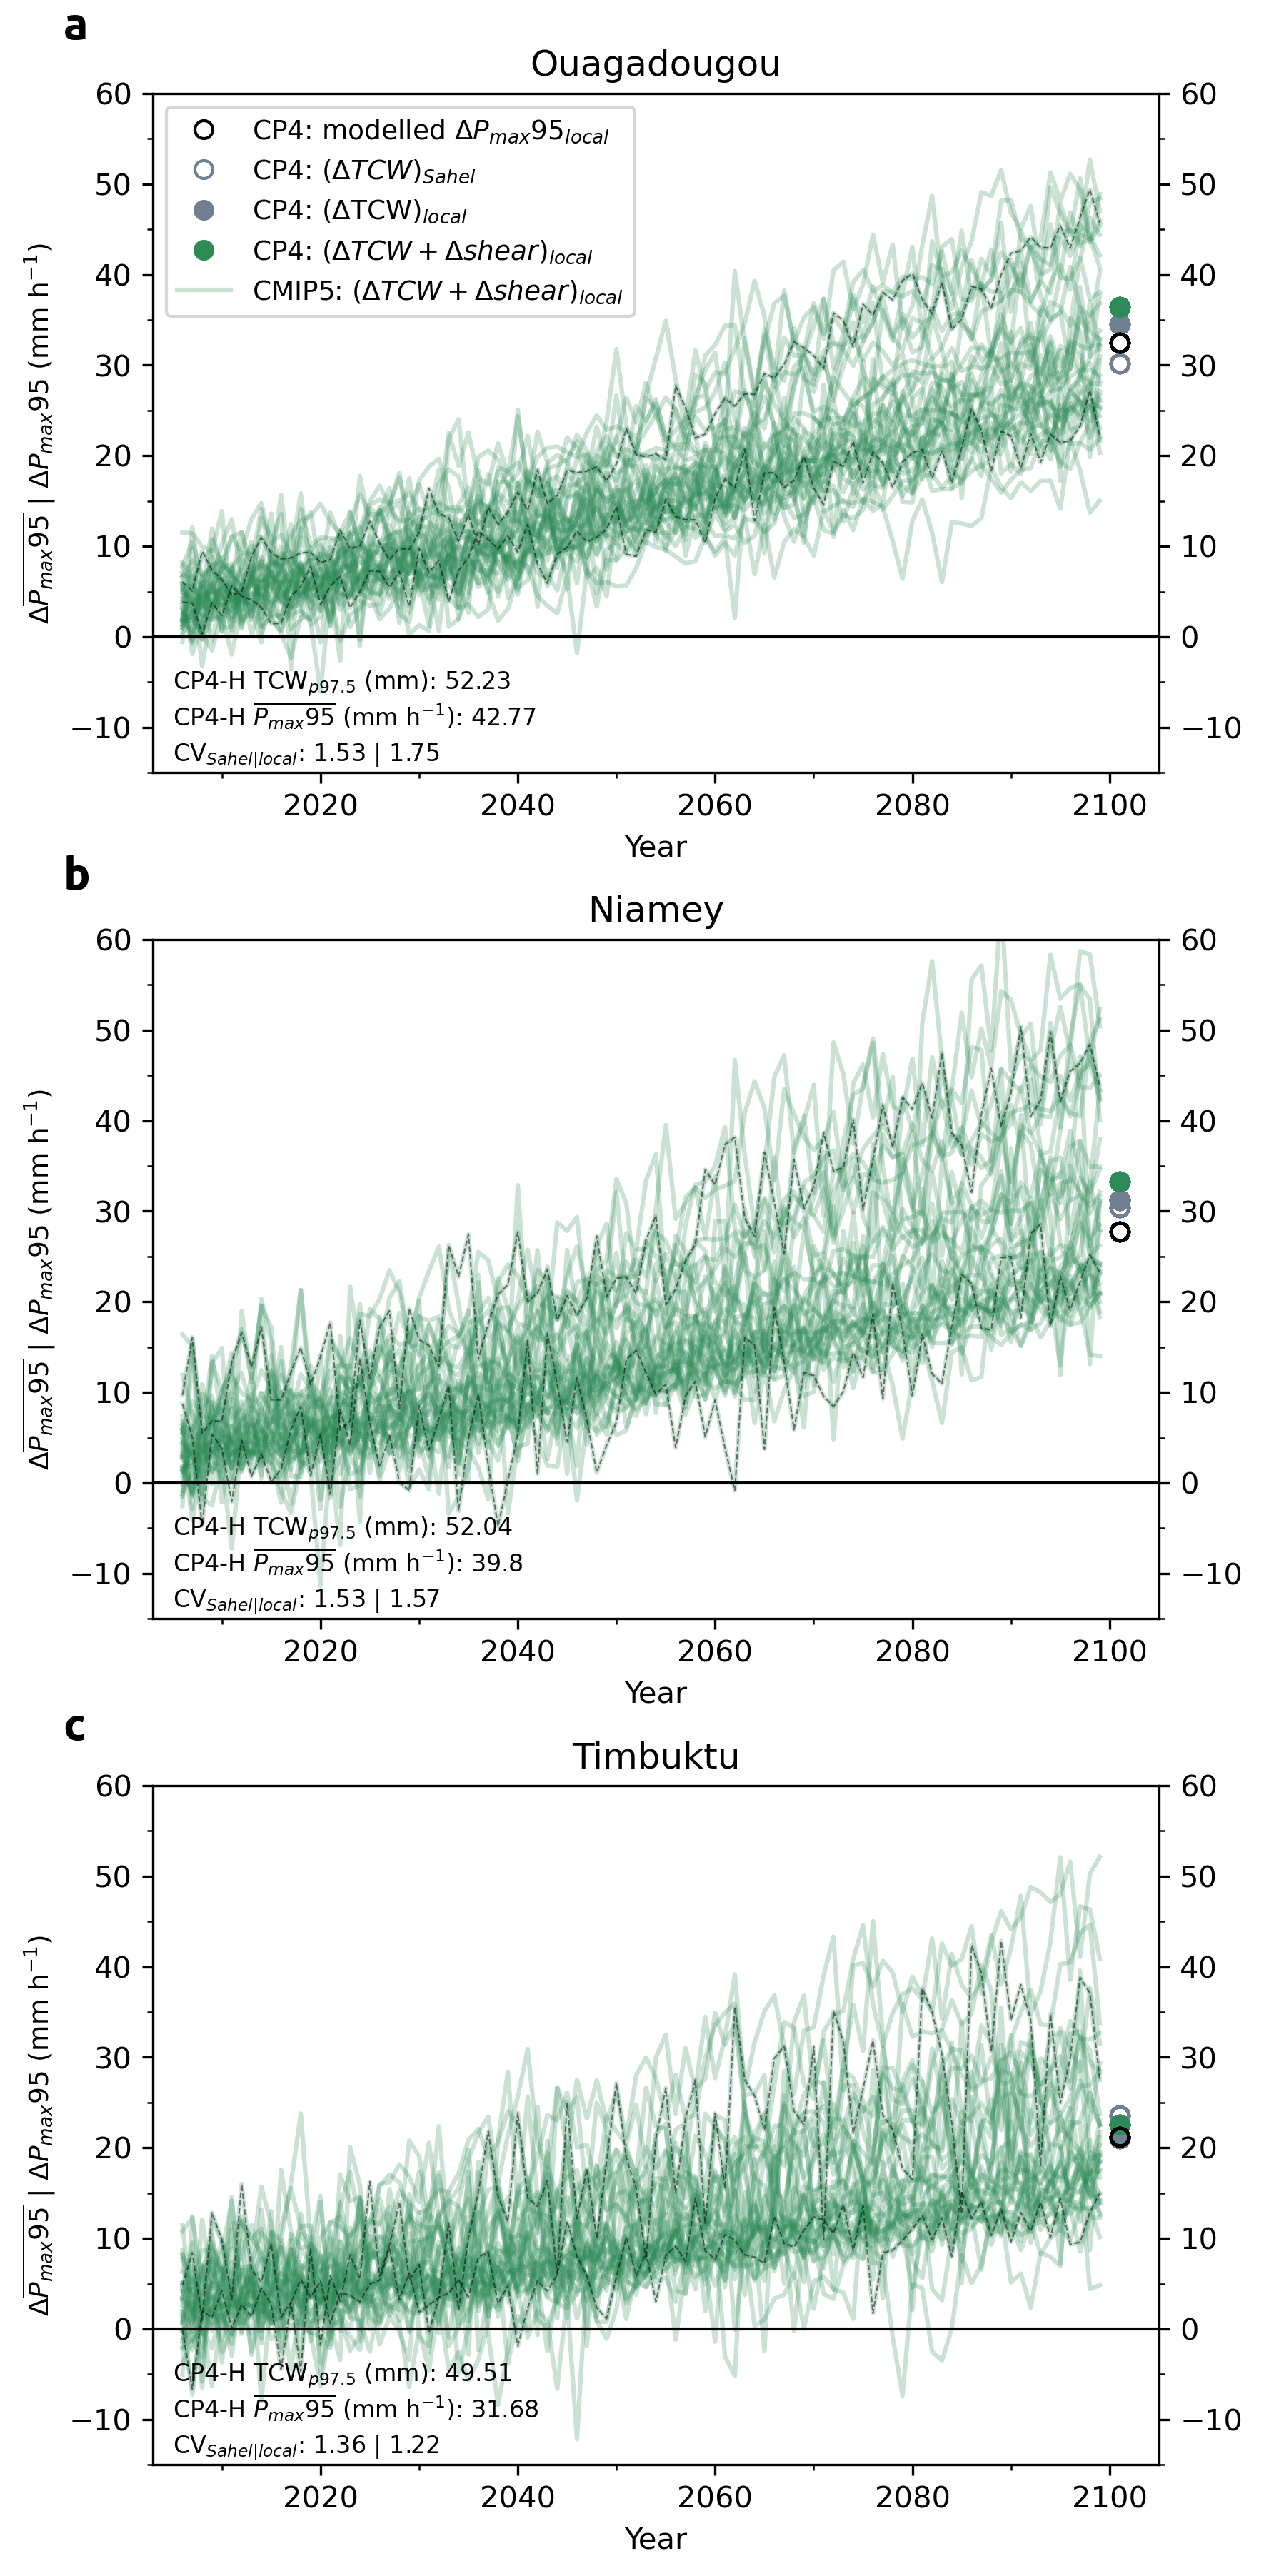

In [62]:
sahel = [-10,15,9,19]
x=2
ouaga=[-1.52-x,-1.52+x,11.38,13.38]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 12.51,14.51] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 15.77,17.77] #16.7666° N, 3.0026° W

regions = {'sahel':(sahel, 'Sahel'), 'ouaga':(ouaga, 'Ouagadougou'), 'niamey':(niamey, 'Niamey'), 'timbuktu':(timbuktu, 'Timbuktu')}

f = plt.figure(figsize=(6,12), dpi=300)

for idss, rname in enumerate(['ouaga', 'niamey', 'timbuktu']):
    ax = f.add_subplot(3,1, idss+1)  #cp4f_mcs_grid-

    region = rname

    domain = (regions[region])[0]
    city = (regions[region])[1]

    fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
    ftcw_sahel = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb")) #'+region+'
    ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors_'+region+'.p', "rb")) #'+region+'

    shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
    tcwvfac_all =  np.array(ftcw['rel']) 
    precip_all = ftcw['prcp_hist']
    
    tcwvfac_all_sahel =  np.array(ftcw_sahel['rel']) 
    precip_all_sahel = ftcw_sahel['prcp_hist']

    dirs = regions
    cp4hist_mcs95, cp4fut_mcs95, obs_mcs95, cp4hist_mcs95_max, cp4fut_mcs95_max, obs_mcs95_max = calc_mcs(dirs[region][0])
    cp4_tcw_hist, cp4_tcw_fut, cp4_tcw_rel, cp4_shear_abs = calc_regional(dirs[region][0])


    isclose = np.nanargmin(np.abs(cp4hist_mcs95['tcwv']-ftcw['tcw_hist']))
    isclose_sahel = np.nanargmin(np.abs(cp4hist_mcs95['tcwv']-ftcw_sahel['tcw_hist']))
    cp4_pos_array95 = tcwvfac_all[isclose]
    cp4_prcp_array95 = ftcw['prcp_hist'][isclose]
    cp4f_prcp_array95 = ftcw['prcp_fut'][isclose]
    
    cp4_pos_array95_sahel = tcwvfac_all_sahel[isclose_sahel]
    cp4_prcp_array95_sahel = ftcw_sahel['prcp_hist'][isclose_sahel]
    cp4f_prcp_array95_sahel = ftcw_sahel['prcp_fut'][isclose_sahel]

    slevels=np.arange(-18,19,3)

    yy ='2020-2100'

    evenly_spaced_interval = np.linspace(0, 1, len(model_names))

    colors = [cm.inferno(x) for x in evenly_spaced_interval]
    cmiplist = []
    cmipmean = []
    for ids, mn in enumerate(model_names.values):
        tcw_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'_'+region+'/prw_*_'+mn+'_*.nc')[0]).squeeze()
        sh_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'_'+region+'/u*_'+mn+'_*.nc')[0]).squeeze()

        tcw_map = tcw_map.where(tcw_map['time.year']<=2099, drop=True)
        sh_map = sh_map.where(sh_map['time.year']<=2099, drop=True)

        ##relative CMIP change
        ds_shear = sh_map['unknown']*shearfac
        cmip_rel = (tcw_map['prw']/tcw_map['prw_hist'])

        years = np.unique(tcw_map['time.year'].values)


        new_ar_list95 =   cmip_rel *cp4_pos_array95 * cp4hist_mcs95['prcp']
        sums95 = new_ar_list95 + ds_shear

        cp4construct95 =  cp4hist_mcs95['prcp'] * cp4_pos_array95 * cp4_tcw_rel['tcwv'].values
        cp4construct95_sahel =  cp4hist_mcs95['prcp'] * cp4_pos_array95_sahel * cp4_tcw_rel['tcwv'].values

        #obs_construct95 =  obs_mcs95['prcp'] * cp4_pos_array95 * cp4_tcw_rel['tcwv'].values

        cp4total95 = cp4construct95 + cp4_shear_abs['u_pl']*shearfac
        cp4total95_sahel = cp4construct95_sahel + cp4_shear_abs['u_pl']*shearfac

        
        
        cmiplist.append(sums95)
        cmipmean.append(np.mean(sums95[-30::]))
        #ax.plot(tcw_map['time.year'].values,new_ar_list, color='slategrey', alpha=0.9, label='CMIP5')
        #ax.plot(2006, cp4hist_mcs['prcp'], marker='o', color='k')
        ax.plot(2101, cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'], marker='o', linestyle='', mfc='none', mec='k', label=r'CP4: modelled $\Delta P_{max}95_{local}$', zorder=99)
        ax.plot(2101, cp4construct95_sahel, marker='o', linestyle='', color='brown', label=r'CP4: ($\Delta TCW)_{Sahel}$', mfc='none', mec='slategrey')
        ax.plot(2101, cp4construct95, marker='o', linestyle='', color='slategrey', label=r'CP4: ($\Delta$TCW)$_{local}$')
        ax.plot(2101, cp4total95, marker='o', linestyle='', color='seagreen', label=r'CP4: ($\Delta TCW+ \Delta shear)_{local}$')
       # ax.plot(2101, obs_construct95, marker='o', linestyle='', color='b', label=r'OBS TCW-constructed')
        #ax.errorbar(2101, cp4construct, yerr=np.array([[cp4construct-cp4construct05,cp4construct95-cp4construct]]).T, marker='o', color='slategrey', linestyle='', label=r'CP4 TCW-constructed')
        #ax.errorbar(2102, cp4total, yerr=np.array([[cp4total-cp4total05,cp4total95-cp4total]]).T, marker='o', color='seagreen', linestyle='', label=r'CP4 [TCW+Shear]-constructed')
        ax.plot(tcw_map['time.year'].values,sums95, color='seagreen', alpha=0.25, label=r'CMIP5: ($\Delta TCW+ \Delta shear)_{local}$ ')
        if (idss==0) & (ids==0):
            plt.legend(fontsize=9, loc='upper left')
            
    meanordered = np.argsort(cmipmean)
    tsordered = np.array(cmiplist)[meanordered]
    pos90 = int(np.round(len(cmipmean)/100*90,0))
    pos10 = int(np.round(len(cmipmean)/100*10,0))
    
  
    ax.plot(tcw_map['time.year'].values,tsordered[pos10], color='k', alpha=0.5, linewidth=0.5, linestyle='dashed')
    ax.plot(tcw_map['time.year'].values,tsordered[pos90], color='k', alpha=0.5, linewidth=0.5, linestyle='dashed')
    
    

    ax.text(2005,-5.8,'CP4-H TCW$_{p97.5}$ (mm): '+str(np.round(cp4hist_mcs95['tcwv'],2)), fontsize=8)
    ax.text(2005,-9.8,'CP4-H $\overline{P_{max}95}$ (mm h$^{-1}$): '+str(np.round(cp4hist_mcs95['prcp'],2)), fontsize=8)
    ax.text(2005,-13.7,'CV$_{Sahel | local}$: '+str(np.round(cp4_pos_array95_sahel,2))+' | '+str(np.round(cp4_pos_array95,2)), fontsize=8)
    ax.set_ylabel('$\Delta \overline{P_{max}95}$ | $\Delta P_{max}95$ (mm h$^{-1}$)', fontsize=9)
    ax.set_xlabel('Year')
    ax.tick_params(axis='y', which='both', labelright='off', labelleft='on', right='on')
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.axhline(0, linestyle='solid', lw=1, color='k')
    ax.set_ylim(-15,60)
    ax.set_xlim(2003,2105)
    ax.set_title(city)
    
plt.tight_layout()

text = ['a', 'b', 'c']
plt.tight_layout()
plt.annotate(text[0], xy=(0.05, 0.98), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[1], xy=(0.05, 0.65), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[2], xy=(0.05, 0.32), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)

f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_all_cities_timeseries_CP4_0.1mm.jpg')

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

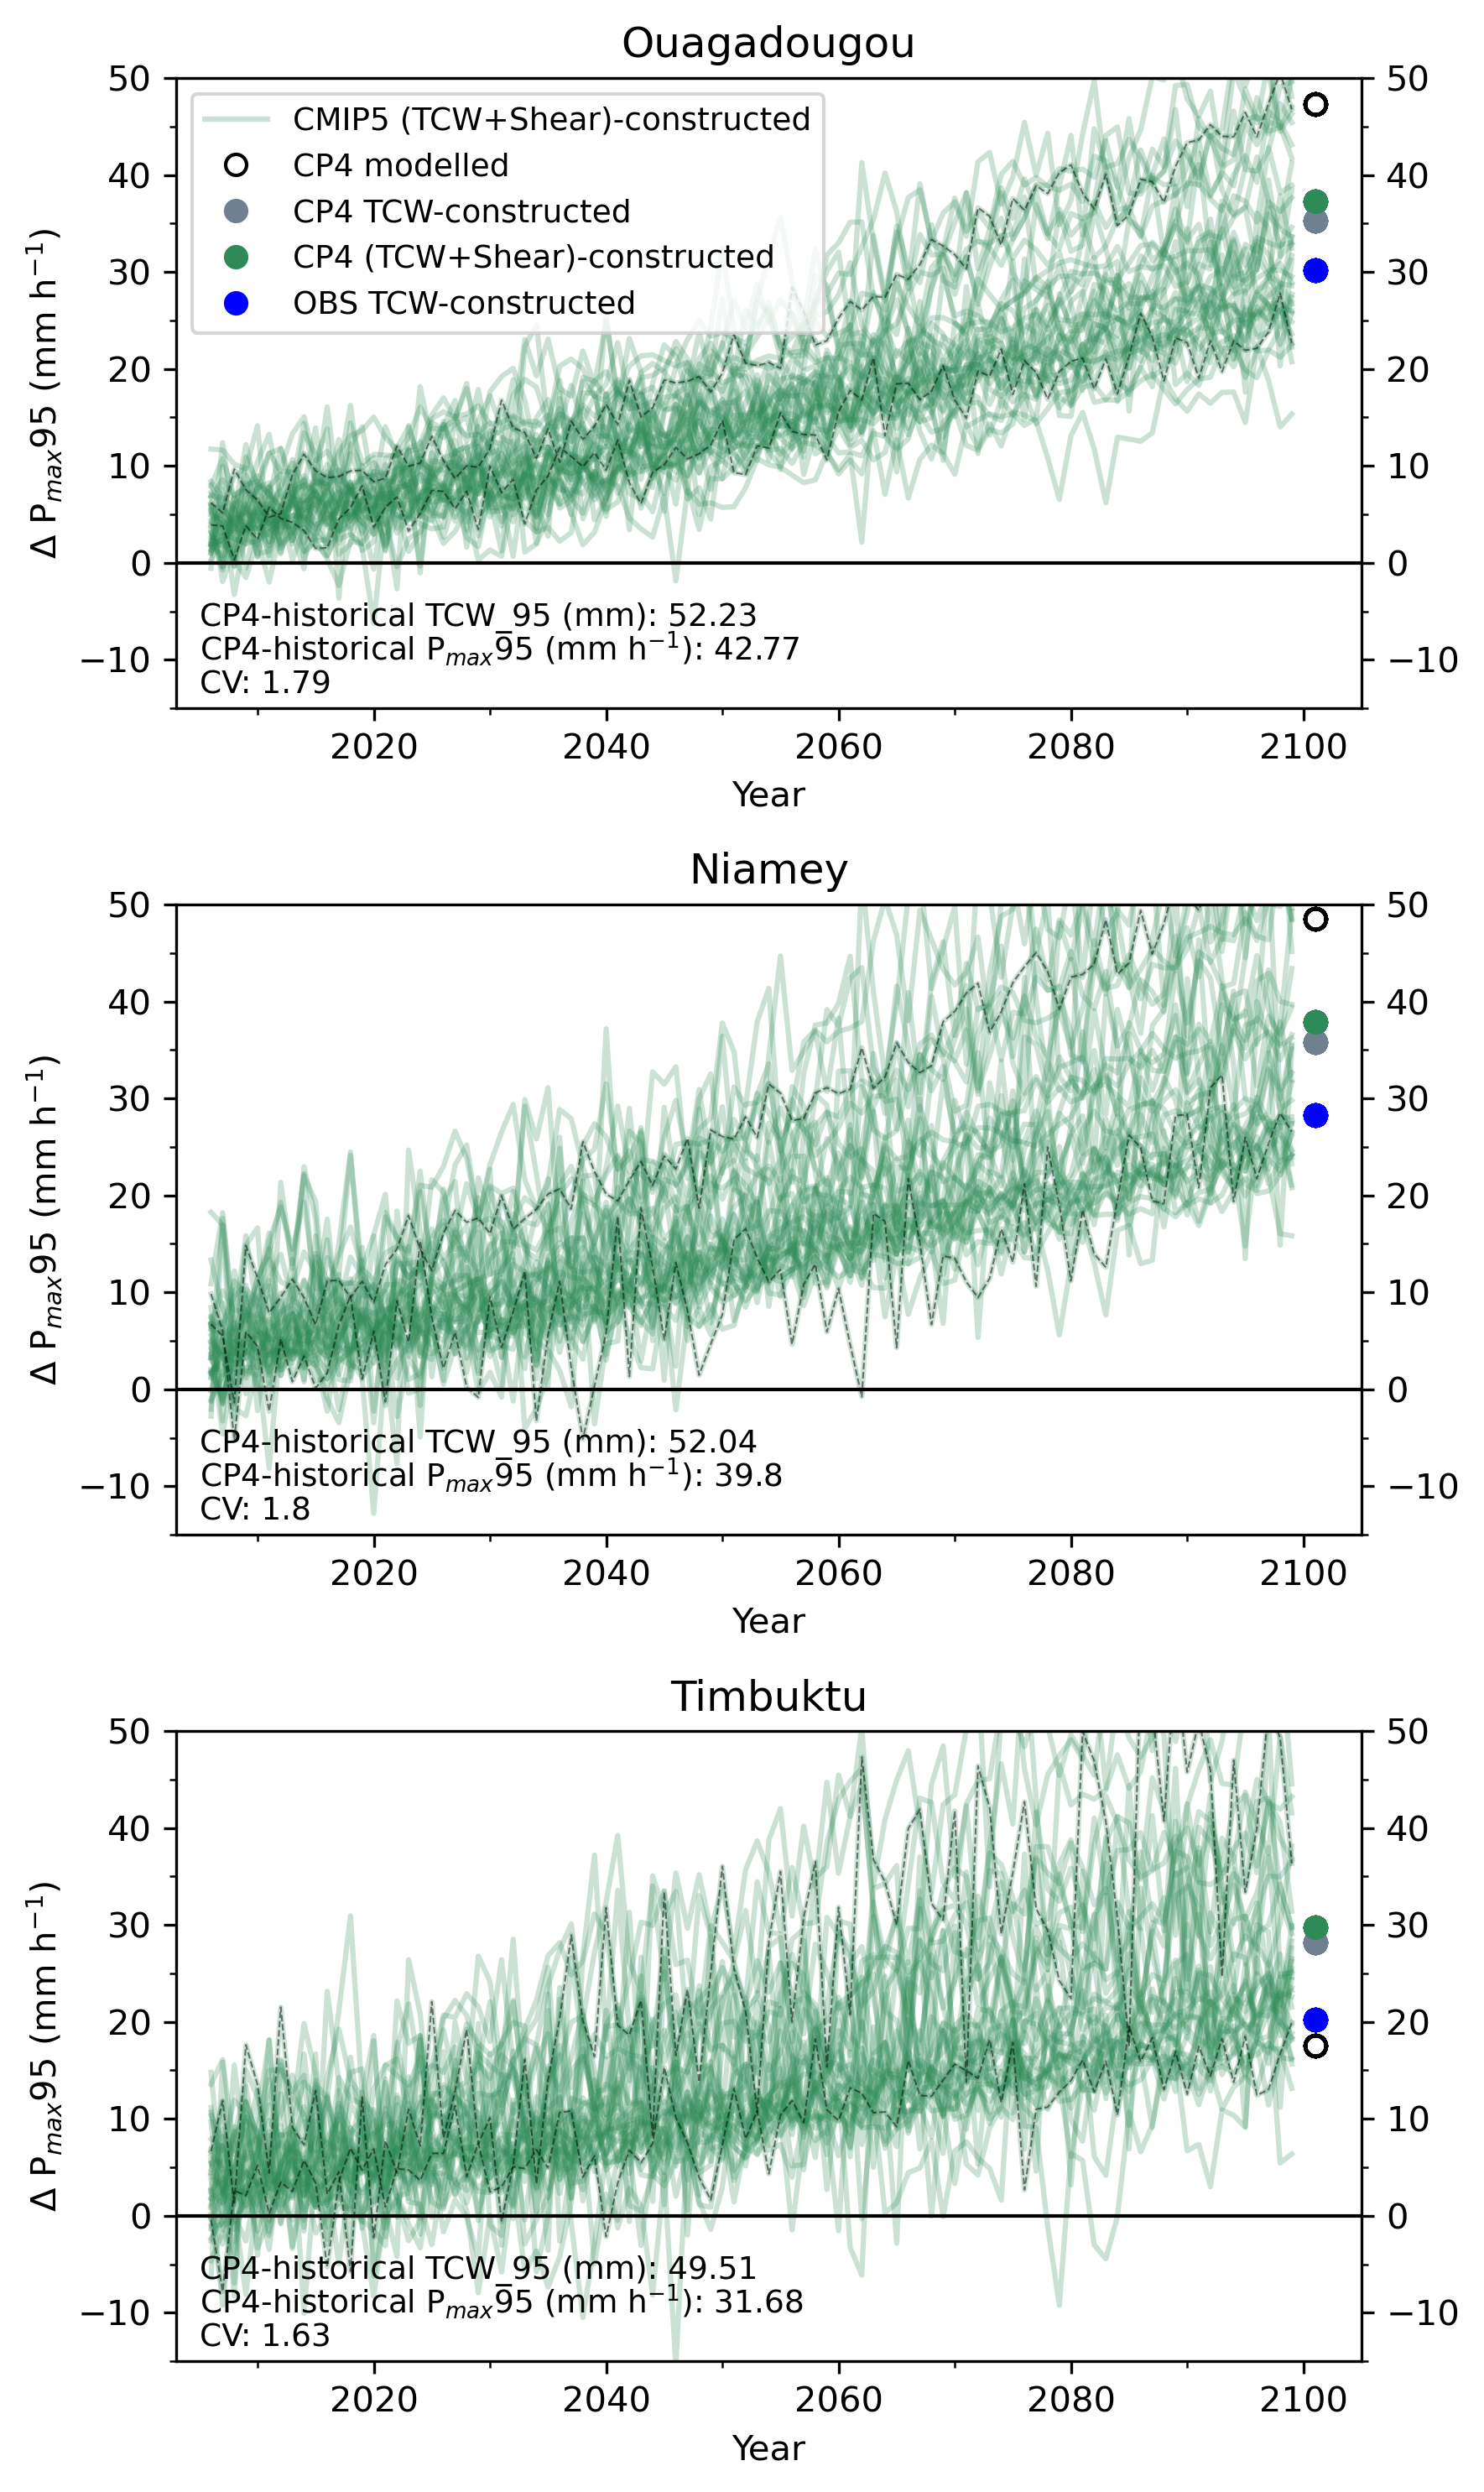

In [44]:
sahel = [-10,15,9,19]
x=2
ouaga=[-1.52-x,-1.52+x,11.38,13.38]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 12.51,14.51] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 15.77,17.77] #16.7666° N, 3.0026° W

regions = {'sahel':(sahel, 'Sahel'), 'ouaga':(ouaga, 'Ouagadougou'), 'niamey':(niamey, 'Niamey'), 'timbuktu':(timbuktu, 'Timbuktu')}

f = plt.figure(figsize=(6,10), dpi=300)

for idss, rname in enumerate(['ouaga', 'niamey', 'timbuktu']):
    ax = f.add_subplot(3,1, idss+1)  #cp4f_mcs_grid-

    region = rname

    domain = (regions[region])[0]
    city = (regions[region])[1]

    fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
    #ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb")) #'+region+'
    ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors_'+region+'.p', "rb")) #'+region+'

    shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
    tcwvfac_all =  np.array(ftcw['rel']) 

    precip_all = ftcw['prcp_hist']

    tcabsfac = np.mean(ftcw['abs']) #1.21 # absolute change

    tcabserr = np.std(ftcw['abs']) #0.06 #mm h
    tcrelerr = np.std(ftcw['rel']) #0.18 #%
    
    dirs = regions
    cp4hist_mcs95, cp4fut_mcs95, obs_mcs95, cp4hist_mcs95_max, cp4fut_mcs95_max, obs_mcs95_max = calc_mcs(dirs[region][0])
    cp4_tcw_hist, cp4_tcw_fut, cp4_tcw_rel, cp4_shear_abs = calc_regional(dirs[region][0])

    #ipdb.set_trace()

    isclose = np.nanargmin(np.abs(cp4hist_mcs95['tcwv']-ftcw['tcw_hist']))
    cp4_pos_array95 = np.max(tcwvfac_all)
    cp4_prcp_array95 = np.max(ftcw['prcp_hist'])
    cp4f_prcp_array95 = np.max(ftcw['prcp_fut'])

    slevels=np.arange(-18,19,3)
    #tag='10'
    yy ='2020-2100'
    #ipdb.set_trace()
    evenly_spaced_interval = np.linspace(0, 1, len(model_names))

    colors = [cm.inferno(x) for x in evenly_spaced_interval]
    cmiplist = []
    cmipmean = []
    for ids, mn in enumerate(model_names.values):
        tcw_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'_'+region+'/prw_*_'+mn+'_*.nc')[0]).squeeze()
        sh_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'_'+region+'/u*_'+mn+'_*.nc')[0]).squeeze()

        tcw_map = tcw_map.where(tcw_map['time.year']<=2099, drop=True)
        sh_map = sh_map.where(sh_map['time.year']<=2099, drop=True)

        #ds_merge = xr.merge([tcw_map, sh_map])

        ##relative CMIP change
        ds_shear = sh_map['unknown']*shearfac
        cmip_rel = (tcw_map['prw']/tcw_map['prw_hist'])

        years = np.unique(tcw_map['time.year'].values)

        
        #ipdb.set_trace()

        #new_ar_list05 =   cmip_rel *cp4_pos_array05 * cp4_prcp_array05#cp4hist_mcs95['prcp']
        new_ar_list95 =   cmip_rel *cp4_pos_array95 * cp4hist_mcs95['prcp']#cp4hist_mcs95['prcp']
       # sums05 = new_ar_list05 + ds_shear
        sums95 = new_ar_list95 + ds_shear

        cp4construct95 =  cp4hist_mcs95['prcp'] * cp4_pos_array95 * cp4_tcw_rel['tcwv'].values
        #cp4construct95 =   cp4_prcp_array95* cp4_pos_array95 * cp4_tcw_rel['tcwv'].values

        obs_construct95 =  cp4f_prcp_array95-cp4_prcp_array95 #obs_mcs95['prcp'] * cp4_pos_array95 * cp4_tcw_rel['tcwv'].values

    #     cp4total = cp4construct + cp4_shear_abs['u_pl']
    #     cp4total05 = cp4construct05 + cp4_shear_abs['u_pl']
        cp4total95 = cp4construct95 + cp4_shear_abs['u_pl']*shearfac

       # print(cp4_shear_abs['u_pl'].values, cp4total95)

       # ax.plot(tcw_map['time.year'].values,sums05, color='k', alpha=0.25, label='CMIP5 [TCW$_{5}$+Shear]-constructed')
        ax.plot(tcw_map['time.year'].values,sums95, color='seagreen', alpha=0.25, label=r'CMIP5 (TCW+Shear)-constructed')
        
        cmiplist.append(sums95)
        cmipmean.append(np.mean(sums95[-30::]))
        #ax.plot(tcw_map['time.year'].values,new_ar_list, color='slategrey', alpha=0.9, label='CMIP5')
        #ax.plot(2006, cp4hist_mcs['prcp'], marker='o', color='k')
        ax.plot(2101, cp4fut_mcs95_max['prcp']-cp4hist_mcs95_max['prcp'], marker='o', linestyle='', mfc='none', mec='k', label=r'CP4 modelled', zorder=99)
        ax.plot(2101, cp4construct95, marker='o', linestyle='', color='slategrey', label=r'CP4 TCW-constructed')
        ax.plot(2101, cp4total95, marker='o', linestyle='', color='seagreen', label=r'CP4 (TCW+Shear)-constructed')
        ax.plot(2101, obs_construct95, marker='o', linestyle='', color='b', label=r'OBS TCW-constructed')
        #ax.errorbar(2101, cp4construct, yerr=np.array([[cp4construct-cp4construct05,cp4construct95-cp4construct]]).T, marker='o', color='slategrey', linestyle='', label=r'CP4 TCW-constructed')
        #ax.errorbar(2102, cp4total, yerr=np.array([[cp4total-cp4total05,cp4total95-cp4total]]).T, marker='o', color='seagreen', linestyle='', label=r'CP4 [TCW+Shear]-constructed')

        if (idss==0) & (ids==0):
            plt.legend(fontsize=9, loc='upper left')
            
    meanordered = np.argsort(cmipmean)
    tsordered = np.array(cmiplist)[meanordered]
    pos90 = int(np.round(len(cmipmean)/100*90,0))
    pos10 = int(np.round(len(cmipmean)/100*10,0))
    
    ax.plot(tcw_map['time.year'].values,tsordered[pos10], color='k', alpha=0.5, label=r'CMIP5 (TCW+Shear)-constructed', linewidth=0.5, linestyle='dashed')
    ax.plot(tcw_map['time.year'].values,tsordered[pos90], color='k', alpha=0.5, label=r'CMIP5 (TCW+Shear)-constructed', linewidth=0.5, linestyle='dashed')
    
    

    ax.text(2005,-6.5,'CP4-historical TCW_95 (mm): '+str(np.round(cp4hist_mcs95['tcwv'],2)), fontsize=9)
    ax.text(2005,-10,'CP4-historical P$_{max}$95 (mm h$^{-1}$): '+str(np.round(cp4hist_mcs95['prcp'],2)), fontsize=9)
    ax.text(2005,-13.5,'CV: '+str(np.round(cp4_pos_array95,2)), fontsize=9)
    ax.set_ylabel('$\Delta$ P$_{max}$95 (mm h$^{-1}$)')
    ax.set_xlabel('Year')
    ax.tick_params(axis='y', which='both', labelright='off', labelleft='on', right='on')
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.axhline(0, linestyle='solid', lw=1, color='k')
    ax.set_ylim(-15,50)
    ax.set_xlim(2003,2105)
    ax.set_title(city)
    
plt.tight_layout()

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_all_cities_timeseries_CP4_0.1mm.jpg')